In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


# Plot style
use_log_y = False  
markers = True     # show markers on curves
line_style = '-'   # solid line
marker_style = 'o' # marker symbol

# Folders / file patterns
traj_path_tpl = 'trajectories/trajectory_{}_{}_{}.pkl'
results_path_tpl = 'results/ucimulti2/{}_{}_{}.dataframe'


# -----------------------------
# HELPERS
# -----------------------------
def load_all_trajectories(methods: List[str], classifier: str, dataset: str) -> Dict[str, List[np.ndarray]]:
    """
    Reads a pickled file that contains a sequence of trajectory states (one after another).
    Returns a dict: {method: [list_of_trajectories_per_bag]}
    where trajectories_per_bag[i] is a list of iteration prevalence vectors for bag i.
    """
    out: Dict[str, List[List[np.ndarray]]] = {}
    for m in methods:
        pkl_file = traj_path_tpl.format(m,classifier,dataset)
        
        buckets = []
        with open(pkl_file, 'rb') as f:
            while True:
                try:
                    buckets.append(pickle.load(f))
                except EOFError:
                    break
        out[m] = buckets
    return out


def load_results_frame(method: str, classifier: str, dataset: str) -> pd.DataFrame:
    csv_file = results_path_tpl.format(method, classifier, dataset)
    return pd.read_csv(csv_file, index_col=0)


def compute_errors_for_bag(
    p_true: np.ndarray,
    trajectory: List[np.ndarray]
) -> List[float]:
    """
    Given the true prevalence vector (p_true) and the trajectory (list of prevalence vectors per iteration),
    compute MAE per iteration: mean(|p_true - p_iter|).
    """
    errs: List[float] = []
    for p_iter in trajectory:
        errs.append(float(np.mean(np.abs(p_true - p_iter))))
    return errs


def parse_prev(s: str) -> np.ndarray:
    # rows look like: "[0.10 0.90]" -> turn into array
    return np.fromstring(s.strip("[]"), sep=" ")


def plot_everthing(methods, method_names, classifier, datasets, bags_by_dataset, grid_cols=4):
    n_rows = len(datasets)
    n_cols = grid_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.6 * n_rows), squeeze=False)


    for r, ds in enumerate(datasets):
        # Load once per dataset
        traj_by_method = load_all_trajectories(methods, classifier, ds)

        # Also load results once per method (cache)
        results_by_method: Dict[str, pd.DataFrame] = {m: load_results_frame(m, classifier, ds) for m in methods}

        # Quick check: all methods must have same number of bags as their results rows
        num_bags_expected = None
        for m in methods:
            t_count = len(traj_by_method[m])
            df_len = len(results_by_method[m])
            if t_count != df_len:
                raise AssertionError(
                    f"[{ds}:{m}] Number of trajectories ({t_count}) != results rows ({df_len})"
                )
            if num_bags_expected is None:
                num_bags_expected = t_count
            else:
                if num_bags_expected != t_count:
                    raise AssertionError(
                        f"[{ds}] Methods disagree on count of bags: {num_bags_expected} vs {t_count}"
                    )

        # Choose bag indices for this dataset
        bag_list = bags_by_dataset.get(ds, [])
        # Ensure length <= n_cols
        if len(bag_list) > n_cols:
            print(f"Warning: dataset '{ds}' has {len(bag_list)} bag ids but grid has only {n_cols} cols; truncating.")
            bag_list = bag_list[:n_cols]

        # Fill columns
        for c in range(n_cols):
            ax = axes[r, c]

            if c >= len(bag_list):
                # nothing to plot in this cell
                ax.axis('off')
                continue

            bag_idx = bag_list[c]
            offset = 0
            # For each method, compute the error curve for this bag and plot in the SAME subplot
            max_iters = 0
            markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h', 'x', '+']
            for i,(m,m_name) in enumerate(zip(methods,method_names)):
                df = results_by_method[m]
                # Using iloc so bag_idx is by position (as in your original code)
                row = df.iloc[bag_idx]
                p_true = parse_prev(row['true-prev'])

                trajectory = traj_by_method[m][bag_idx]  # list of prevalence vectors over iterations

                #When we finish plotting all the methods, we plot PCC as a reference
                if m is methods[0]:
                    pcc = trajectory[0]
                    max_trajectory_len = 0
                    for m_ in methods:
                        if len(traj_by_method[m_][bag_idx])>max_trajectory_len:
                            max_trajectory_len = len(traj_by_method[m_][bag_idx])
                    error_pcc = np.repeat(np.mean(np.abs(p_true-pcc)),max_trajectory_len)
                    iters = np.arange(1, max_trajectory_len + 1)
                    markevery = max_trajectory_len//10
                    ax.plot(iters, error_pcc, linestyle='--', label='PCC',markevery=markevery,alpha=0.7)
                
                errors = compute_errors_for_bag(p_true, trajectory)
                
                iters = np.arange(1, len(errors) + 1)
                marker_style = markers[i % len(markers)]
                offset +=5
                if markers:
                    ax.plot(iters, errors, marker=marker_style, linestyle=line_style, label=m_name, alpha=0.7,markevery=(offset,markevery))
                else:
                    ax.plot(iters, errors, linestyle=line_style, label=m_name, alpha=0.7)


                if len(errors) > max_iters:
                    max_iters = len(errors)


            ax.set_title(f"{ds} — bag #{bag_idx}")
            ax.set_xlabel("Iteration")
            if c == 0:
                ax.set_ylabel("Absolute Error")
            if use_log_y:
                ax.set_yscale('log')
            ax.grid(True, which='both', axis='both')
            ax.legend(loc='best', fontsize='small')
            

    # Tidy up empty y labels for single-row cases
    if n_rows == 1:
        for c in range(n_cols):
            if c != 0 and axes[0, c].has_data():
                axes[0, c].set_ylabel("")

    plt.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()


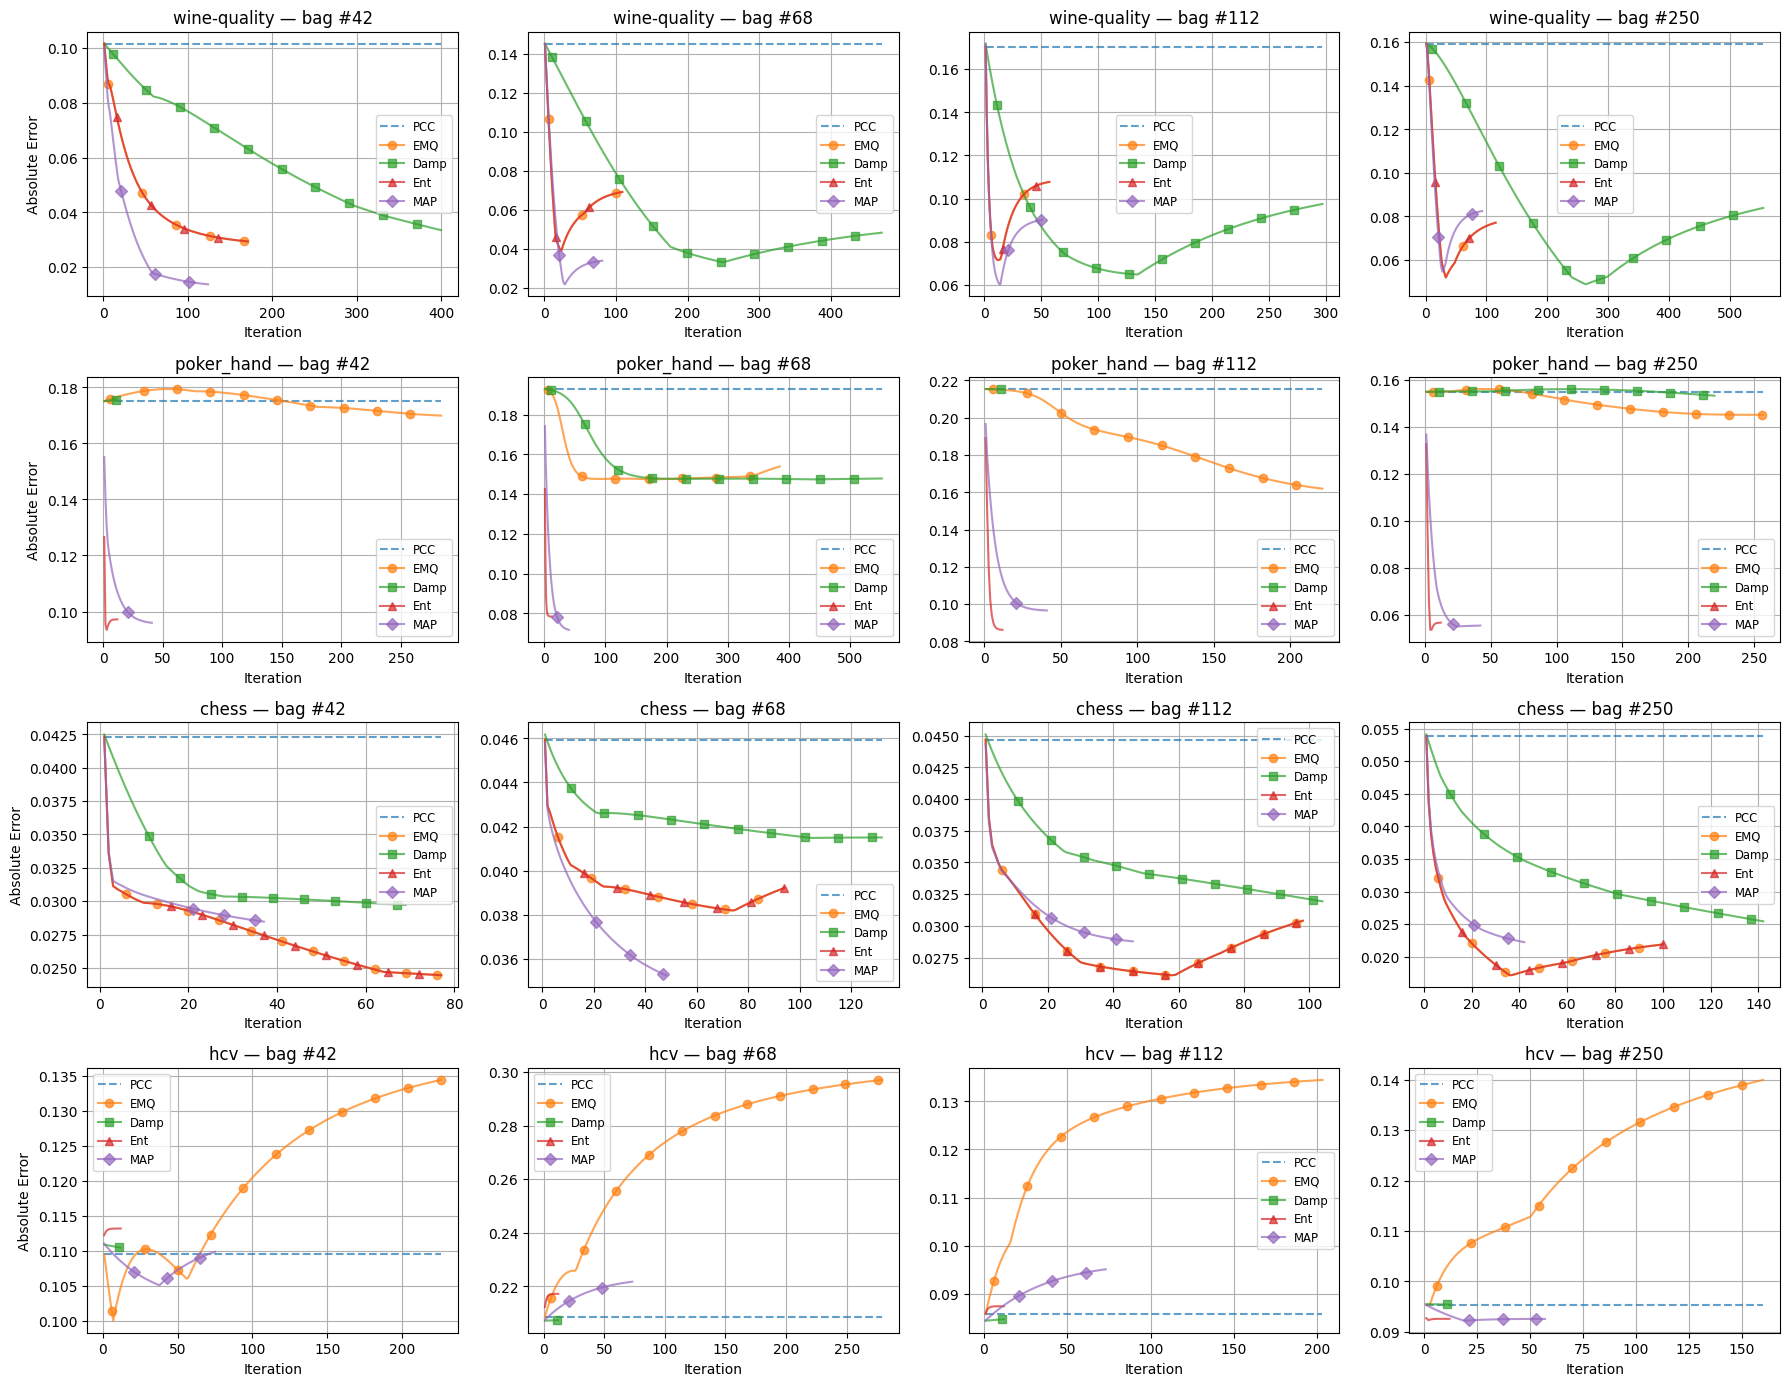

In [2]:
# -----------------------------
# CONFIG — edit these as needed
# -----------------------------
classifier = 'LR'

# Compare several methods in the SAME plot (per subplot)
methods = ['EM','DEM','EREM','DMAPEM'] 
method_names = ['EMQ','Damp','Ent','MAP']  # for legend

# Number of subplot columns per dataset (e.g., 4)
grid_cols = 4

# For each dataset, specify the bag numbers (index into your .dataframe / trajectories list)
# If a dataset has fewer than grid_cols bag numbers, remaining subplots will be empty.
bags_by_dataset: Dict[str, List[int]] = {    
    'wine-quality': [42, 68, 112, 250],
    'poker_hand': [42, 68, 112, 250],
    'chess': [42, 68, 112, 250],
    'hcv': [42, 68, 112, 250],
}
datasets = list(bags_by_dataset.keys())

plot_everthing(methods, method_names, classifier, datasets, bags_by_dataset)

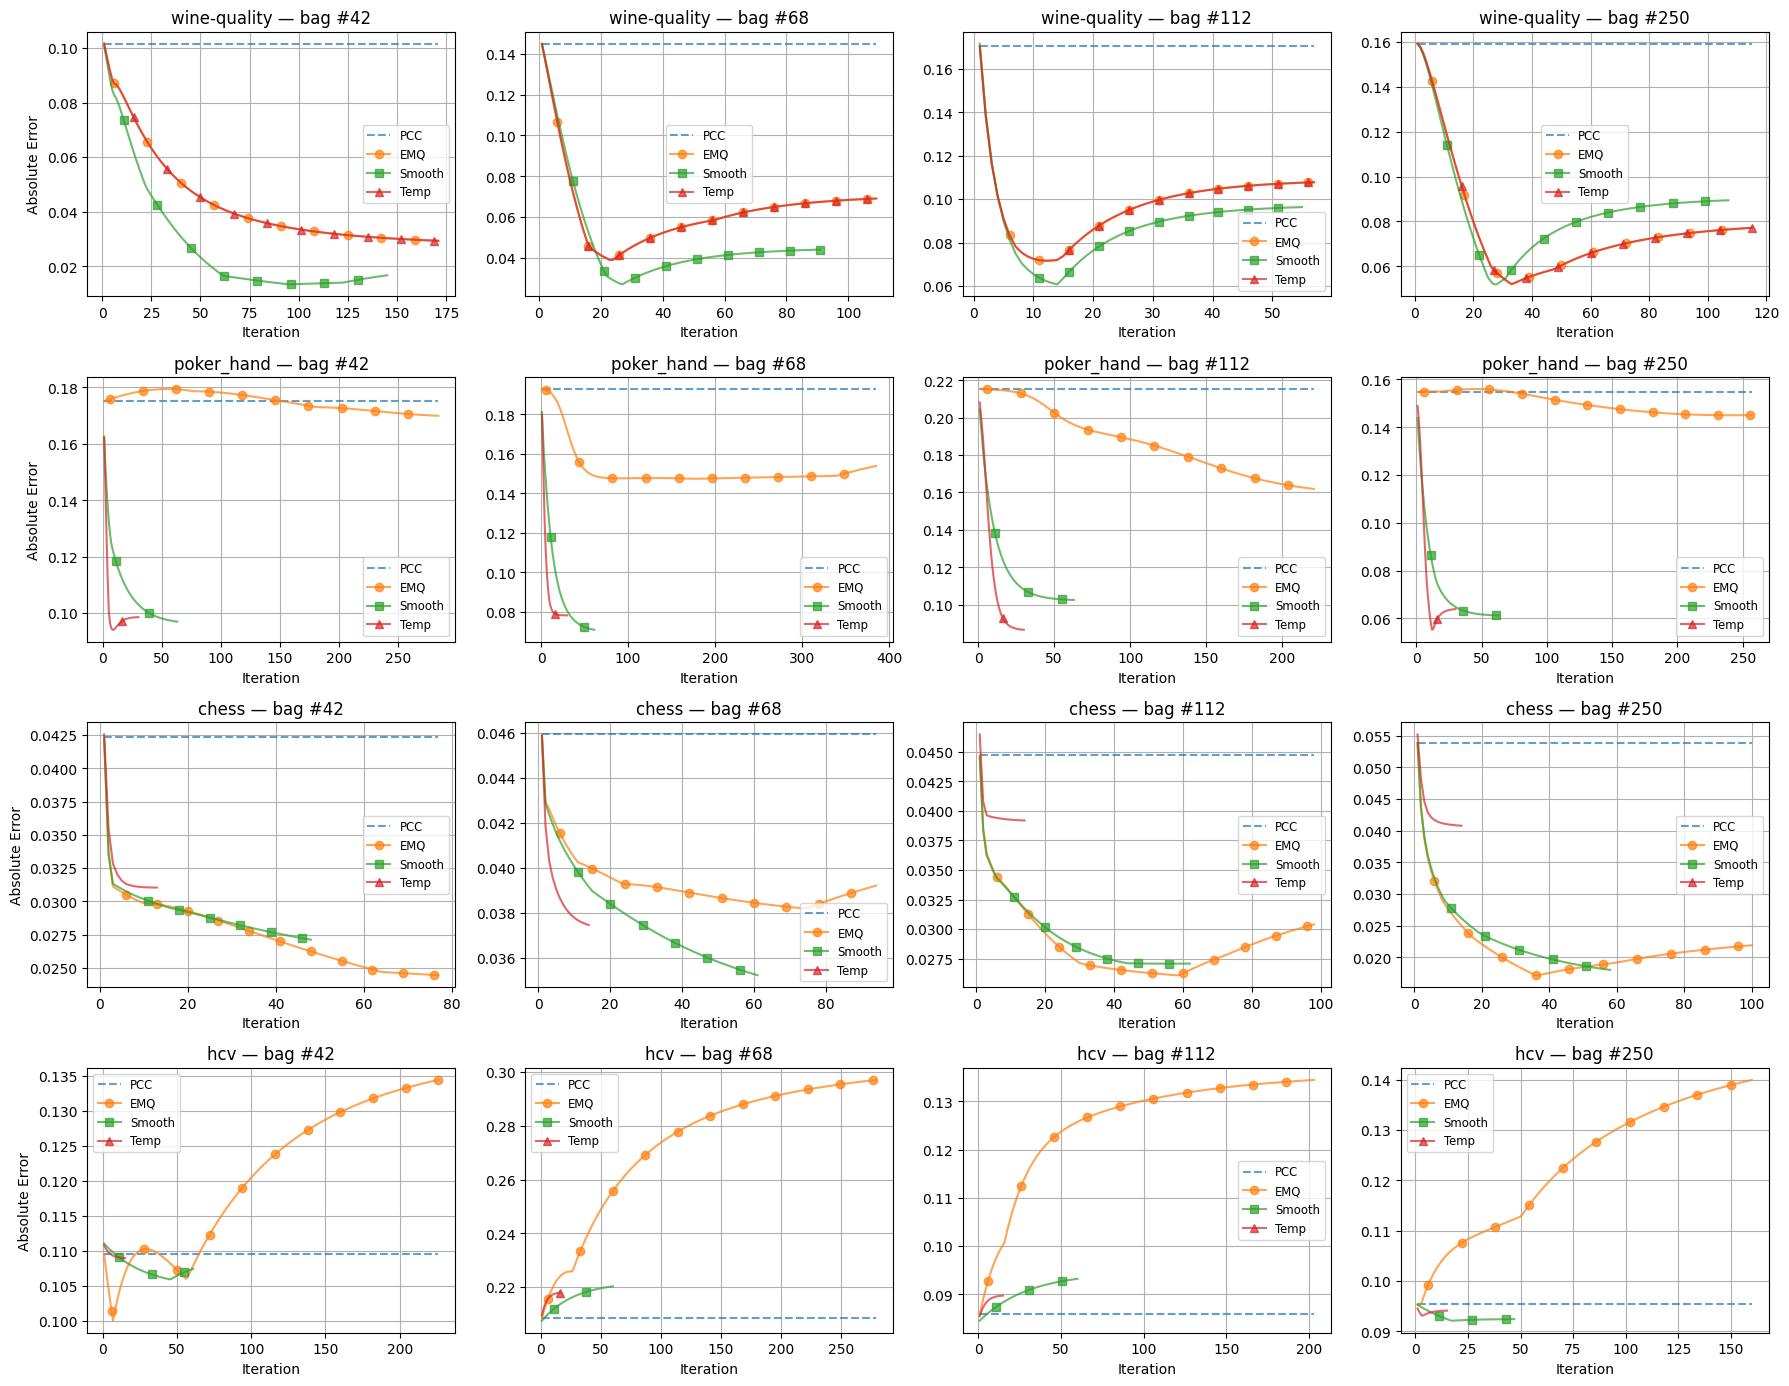

In [3]:
# -----------------------------
# CONFIG — edit these as needed
# -----------------------------
classifier = 'LR'

# Compare several methods in the SAME plot (per subplot)
methods = ['EM','PSEM','TSEM'] 
method_names = ['EMQ','Smooth','Temp']  # for legend

# Number of subplot columns per dataset (e.g., 4)
grid_cols = 4

plot_everthing(methods, method_names, classifier, datasets, bags_by_dataset)